In [56]:
#Tabular Playground Series - Jun 2021
#Link Below
#https://www.kaggle.com/competitions/tabular-playground-series-jun-2021

#Lundquist Griffin griffin.lundquist@studio.unibo.it,
#McCallan Oliver, oliver.mccallan@studio.unibo.it
#Mendoza Alberto, alberto.mendozaperea@studio.unibo.it
#Simon Christopher, ronald.simon@studio.unibo.it
#Lanccetti Valerico, valerico.laccetti@studio.unibo.it




import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [57]:
train_size = 0.01 # train size chosen to have a few tousands of elements
cutoff_variance = .8 # the total amount of variance explained by the selected transformed features
cv = 5
random_state = 42
np.random.seed(random_state) # this sets the random sequence. Setting only this the repeatability is guaranteed
                             # only if we re-execute the entire notebook

train_ds = pd.read_csv('./train.csv')
test_ds = pd.read_csv('./test.csv')

print("Shape of the training data {}".format(train_ds.shape))
print("Shape of the testing data {}".format(test_ds.shape))

Shape of the training data (200000, 77)
Shape of the testing data (100000, 76)


In [58]:
# show 10 random records
train_ds.sample(n=10, axis=0, replace=False, random_state = random_state)

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
119737,119737,0,0,15,0,0,0,0,0,11,...,0,0,1,0,0,0,1,0,0,Class_3
72272,72272,0,0,1,0,0,1,0,0,0,...,0,0,0,0,3,0,0,0,0,Class_6
158154,158154,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,Class_6
65426,65426,6,0,0,0,0,2,0,0,0,...,3,7,2,1,0,0,0,1,1,Class_8
30074,30074,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,Class_1
23677,23677,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,Class_2
134858,134858,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,1,0,0,0,Class_9
176418,176418,0,0,0,0,0,14,0,0,0,...,0,0,1,1,1,2,0,0,0,Class_2
132467,132467,0,2,1,3,1,0,0,7,8,...,0,1,0,0,20,18,1,0,1,Class_8
4082,4082,40,0,0,0,0,0,0,2,0,...,0,1,0,0,0,0,0,0,0,Class_5


In [59]:
# number of unique values
train_ds.nunique().sort_values(ascending=False)[:30]

id            200000
feature_15       105
feature_60        99
feature_59        92
feature_73        91
feature_46        87
feature_28        78
feature_32        77
feature_54        72
feature_61        70
feature_63        70
feature_19        66
feature_55        65
feature_47        63
feature_62        61
feature_3         59
feature_29        58
feature_67        57
feature_41        56
feature_5         55
feature_22        55
feature_43        53
feature_69        52
feature_9         51
feature_74        50
feature_24        50
feature_51        49
feature_27        49
feature_70        49
feature_2         48
dtype: int64

In [60]:
target = 'target'
classes = train_ds[target].unique()
classes.sort()
print(classes)

['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5' 'Class_6' 'Class_7'
 'Class_8' 'Class_9']


In [61]:
# create X_full
le = LabelEncoder() # Ricava una lista di interi che codificano i labels, posizione per posizione
# display(train_ds[target])
y = le.fit_transform(train_ds[target]) # mappa(id, Class_K) -> [ ... K-1 ... ]
# print(y)

X_full = train_ds.drop(['id', target], axis=1)

In [62]:
# show X_full
X_full.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
0,0,0,6,1,0,0,0,0,7,0,...,3,0,0,0,0,0,0,2,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,3,0,0,...,8,0,0,0,0,1,0,0,0,0
3,0,0,7,0,1,5,2,2,0,1,...,0,0,4,0,2,2,0,4,3,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
model_lbls = ['dt' # decision tree
             #,'nb' # gaussian naive bayes
             ,'rf'   # random forest
             #,'lp'   # linear perceptron
             #,'svc'  # support vector
             #,'knn'  # k nearest neighbours
             #,'adb'  # adaboost
            ]

models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-12,-1)]}]
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(random_state=random_state),
           'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state),
           'param': [{'kernel': ['rbf'],
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],
                    },
                   ]
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state),
           'param': [{'n_estimators':[20,30,40,50]
                     ,'learning_rate':[0.5,0.75,1,1.25,1.5]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{
                      # 'max_depth': [*range(4,30)]
                      'max_depth': [*range(4,30,4)]
                    #  ,'n_estimators':[*range(20,80,5)]
                     ,'n_estimators':[*range(10,30,5)]
                     ,'class_weight': [None,'balanced']
                      }]
          }

}


[0.11669831 0.07591789 0.05308423 0.04570598 0.03864043 0.03184003
 0.03012308 0.02934325 0.02765308 0.02628103 0.02476721 0.02408011
 0.02304794 0.02192776 0.02063361 0.01896836 0.01795094 0.0171754
 0.01612948 0.01516765 0.01461421 0.01389225 0.01325595 0.0127744
 0.01232842 0.01184508 0.01162701 0.0112386  0.01072903 0.01029036
 0.00927199 0.00903617 0.00854496 0.00809131 0.00792701 0.00746077
 0.00720115 0.00693542 0.00688668 0.00686254 0.0067852  0.00669558
 0.00657856 0.00651044 0.00635624 0.00599466 0.00556866 0.00544044
 0.00524656 0.00504432 0.00483356 0.00411028 0.00381469 0.00372358
 0.00369381 0.00351625 0.00343449 0.00327978 0.00318041 0.00311074
 0.00272257 0.00270213 0.00238233 0.00218239 0.00211184 0.00206021
 0.00195977 0.0019241  0.00183644 0.00167358 0.00156027 0.00137893
 0.00124575 0.00088061 0.00051175]


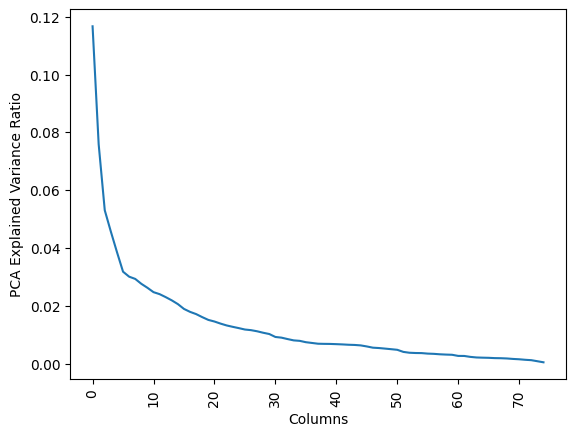

In [64]:
pca = PCA()

# display(X_full)
X_trans = pca.fit_transform(X_full)

## MODIIFICHE
# 1)    Le colonne di X_trans sono combinazioni lineari delle colonne originali di X_full.
#
# 2)    X_full contiene l'intera varianza dei dati originali. 
#       X_trans cattura la varianza dei dati in modo più concentrato, con le prime componenti 
#       principali che spiegano la maggior parte della varianza totale.
#
# 3)    Le colonne di X_trans sono non correlate tra loro

print(pca.explained_variance_ratio_) # per ogni colonna è stata memorizzata la varianza durante l'addestramento

plt.plot(range(X_full.shape[1]), pca.explained_variance_ratio_) # Associamo ad ogni colonna la varianza usata

plt.xlabel('Columns')
plt.ylabel('PCA Explained Variance Ratio')

plt.xticks(rotation = 90)

plt.show()
# Il grafico sarà monotono decrescente perchè con PCA la rappresentatività dei dati cala sempre più andiamo avanti coi dati

In [65]:
explained_variances = pca.explained_variance_ratio_

# Sort the explained variance ratios in descending order
sorted_variances = sorted(explained_variances, reverse=True)
# display(sorted_variances)

# Calculate the cumulative sum of the explained variance ratios
cumulative_variances = np.cumsum(sorted_variances)
# display(cumulative_variances)
# In questo modo abbiamo ottenuto un array di somme che funziona così:
# cumulative_variances[K] = somma dei primi K elementi di 'sorted_variances'

# Find the index i of the first principal component where the cumulative sum exceeds 0.05
cutoff_index = np.argmax(cumulative_variances > cutoff_variance)
print("Used the top {} transformed variables".format(cutoff_index))

# Keep the first i principal components and discard the rest -> the most meaningful
X = pca.transform(X_full)[:, :cutoff_index+1]

Used the top 30 transformed variables


In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y
                                                    , train_size = train_size
                                                    , random_state = random_state) # default Train 0.75- Test 0.25
print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X.shape[1]))

There are 2000 samples in the training dataset
There are 198000 samples in the testing dataset
Each sample has 31 features


In [50]:
np.unique(y_train, return_counts=True)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

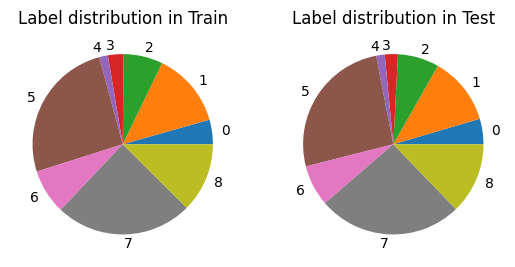

In [82]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)

# IMPORTANTE
# pie(np.unique(y_train, return_counts=True)[0] contiene i singoli label unici
# pie(np.unique(y_train, return_counts=True)[1] contiene i conteggi di quante volte si sono ripetuti in y i singoli label

# VERSIONE CORRETTA
ax1.pie(np.unique(y_train, return_counts=True)[1], labels=np.unique(y_train, return_counts=True)[0]);
ax1.set_title("Label distribution in Train")
ax2.pie(np.unique(y_test, return_counts=True)[1], labels=np.unique(y_test, return_counts=True)[0]);
ax2.set_title("Label distribution in Test")

# # PER VEDERE CAMBIAMENTO IN VALORE ASSOLUTO
# ax1.pie(np.unique(y_train, return_counts=True)[1], labels=np.unique(y_train, return_counts=True)[1]);
# ax1.set_title("Label distribution in Train")
# ax2.pie(np.unique(y_test, return_counts=True)[1], labels=np.unique(y_test, return_counts=True)[1]);
# ax2.set_title("Label distribution in Test")

plt.show()

In [68]:
scorings = ['accuracy'
            # ,'precision_macro'
            # ,'recall_macro'
            ,'f1_macro'
            ]

In [69]:
from sklearn.model_selection import ParameterGrid
trials = {lbl: len(list(ParameterGrid(models[lbl]['param']))) for lbl in model_lbls}
trials

{'dt': 38, 'rf': 56}

In [70]:
clfs = []
results = pd.DataFrame(columns=['scoring','model','best_params','accuracy','precision_macro','recall_macro','f1_macro'])

In [71]:
#grid search cv
for scoring in scorings:
    for m in model_lbls:
        clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=cv,
                           scoring = scoring,

                           )
        clf.fit(X_train, y_train)
        clfs.append(clf)
        y_true, y_pred = y_test, clf.predict(X_test)
        # y_preds.append(y_pred)
        cr = classification_report(y_true,y_pred, output_dict=True
                                   , zero_division=1
                                   )
        results.loc[len(results)] = [scoring,models[m]['name'],clf.best_params_
                                    # ,(clf.cv_results_['mean_fit_time'].sum()+clf.cv_results_['mean_score_time'].sum())*n_splits
                                    ,cr['accuracy']
                                    ,cr['macro avg']['precision']
                                    ,cr['macro avg']['recall']
                                    ,cr['macro avg']['f1-score']]


In [72]:
for score in scorings:
    scoring_filter = score
    display(results[results.scoring==scoring_filter]\
                .sort_values(by=scoring_filter,ascending=False)\
                .drop('scoring',axis=1)\
                .style.format(precision=3)\
                .set_caption('Results for scoring "{}"'.format(scoring_filter)))

,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
1,Random forest,"{'class_weight': None, 'max_depth': 4, 'n_estimators': 25}",0.327,0.679,0.163,0.130
0,Decision Tree,"{'class_weight': None, 'max_depth': 3}",0.307,0.682,0.148,0.126


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
3,Random forest,"{'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 25}",0.264,0.155,0.163,0.157
2,Decision Tree,"{'class_weight': None, 'max_depth': 7}",0.283,0.149,0.148,0.133


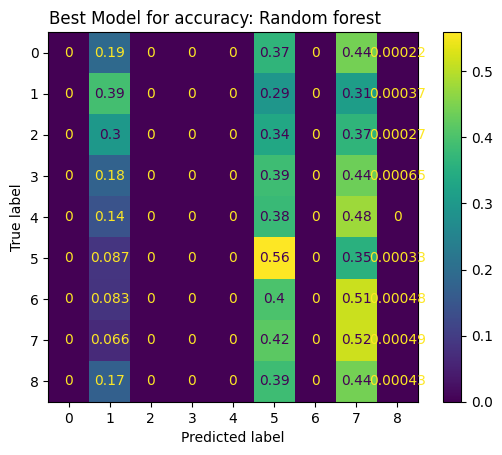

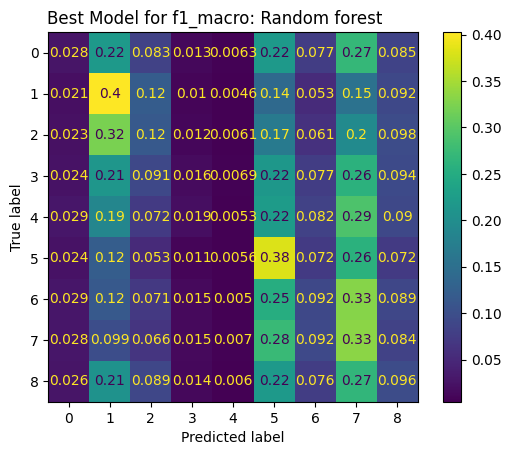

In [77]:
for score in scorings:
    scoring_filter = score
    # bests[score] = results.loc[results.scoring==scoring_filter,scoring_filter].idxmax(axis=0)
    best_row = results.loc[results.scoring==scoring_filter,scoring_filter].idxmax(axis=0)

    # IMPORTANTE
    # Normalizzare le condizioni vere in una matrice di confusione è una pratica utile per ottenere una visione più 
    # dettagliata e comparabile delle prestazioni di un modello di classificazione, soprattutto quando si affrontano 
    # dataset con classi di dimensioni diverse.
    disp = ConfusionMatrixDisplay.from_estimator(X=X_test, y=y_test, estimator = clfs[best_row], normalize='true')
    
    # disp.ax_.set_title("Best Model for {}: {}".format(score,results.at[bests[score],'model']))
    disp.ax_.set_title("Best Model for {}: {}".format(score,results.at[best_row,'model']))
plt.show()

In [78]:
# final test with best model trained on all (train) data
X_u_test = pca.transform(test_ds.drop('id', axis=1))[:, :cutoff_index+1]

In [79]:
scoring_filter = 'f1_macro'
best_row = results.loc[results.scoring==scoring_filter,scoring_filter].idxmax(axis=0)
y = clf.best_estimator_.predict(X_u_test)

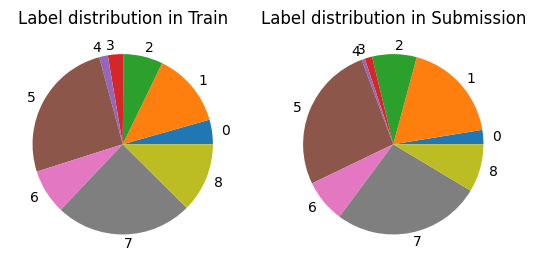

In [83]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
ax1.pie(np.unique(y_train, return_counts=True)[1], labels=np.unique(y_train, return_counts=True)[0]);
# ax1.pie(np.unique(y_train, return_counts=True)[1], labels=np.unique(y_train, return_counts=True)[1]);
ax1.set_title("Label distribution in Train")
ax2.pie(np.unique(y, return_counts=True)[1], labels=np.unique(y, return_counts=True)[0]);
# ax2.pie(np.unique(y, return_counts=True)[1], labels=np.unique(y, return_counts=True)[1]);
ax2.set_title("Label distribution in Submission")
plt.show()